In [60]:
import pickle as pkl

In [61]:
filename = "sim_results/market-marl-nash-3-05-02-2022-15-55-5640_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [62]:
l = list(dir(res))

In [63]:
import numpy as np
import seaborn as sns

In [64]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

In [65]:
res.marl_params

{'epochs': 40,
 'explore_epsilon': 0.05,
 'max_steps': 3,
 'sync_freq': 30,
 'mem_size': 101333,
 'turbo_max_evals': 5,
 'turbo_batch_size': 5,
 'turbo_n_init': 5,
 'batch_size': 5}

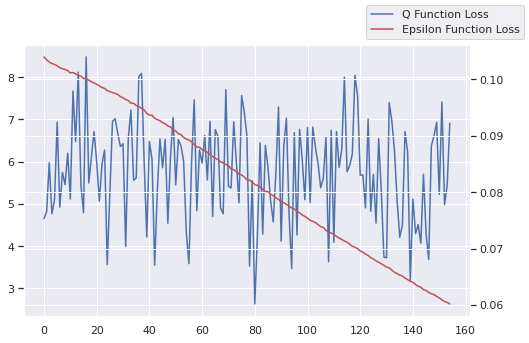

In [66]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

# data_losses_df.plot(y="Nash Net Loss", ax=ax2, legend=False, color="r")
# ax.figure.legend()

data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()


In [67]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)

<AxesSubplot:>

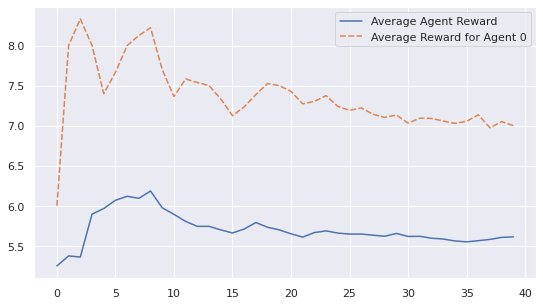

In [68]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [90]:
from environment.TheoreticalMarket import *
import numpy as np

# Theoretical Data
# tm = TheoreticalMarket(beta0 = 30, beta1 = -1.1, beta2 = -2, a = 0.1, ref_p = 1.5)
# beta0 = 25
# beta1 = -0.9
# beta2 = -1.1
# a = 0.1

# Market 3
beta0 = 15
beta1 = -1.05
beta2 = -3.1
a = 0.1

# Simulation Data
ep = 2
# ref_prices = res.state_tracker_epoch[ep]
ref_prices = res.state_tracker[ep]

episode_rewards = res.episode_rewards[ep]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[ep]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.gamma / self.demand_func(x)) - (1 / x)
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  return self.gamma / (self.demand_func(x) * x )
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:52: RuntimeWarning: invalid value encountered in double_scalars
  square_term = np.max([0, np.power(c1, 2) - c1 + 4*(c2 -1)*c2 - 2*c2])


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

# min_eps_price, max_eps_price = get_eps0_range(9.9, Y, X, z)

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

# Episode rewards 


In [91]:
avg_ag_rewards = episode_rewards.mean(axis = 1)
avg_ag_actions= episode_joint_actions.mean(axis = 1)

<AxesSubplot:>

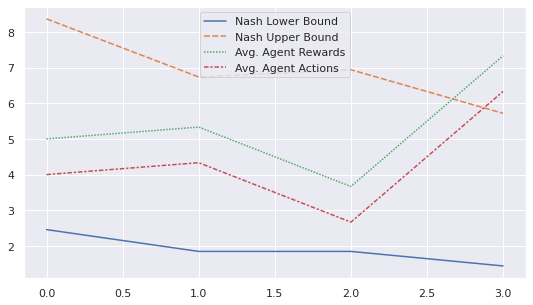

In [93]:
# "Ref Prices": ref_prices, 
nash_bound_per_run = {"Nash Lower Bound": nash_lower_bound, "Nash Upper Bound": nash_upper_bound, "Avg. Agent Rewards": avg_ag_rewards, "Avg. Agent Actions": avg_ag_actions}
nash_bound_per_run_df = pd.DataFrame(data=nash_bound_per_run)

sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=nash_bound_per_run_df)

In [73]:
nash_bound_per_run_df

,Nash Lower Bound,Nash Upper Bound,Avg. Agent Rewards
0,2.456531,8.368980,5.000000
1,1.844898,6.737959,5.333333
2,1.844898,6.941837,3.666667
3,1.437143,5.718571,7.333333


In [74]:
res.episode_rewards[0]

array([[ 6.,  5.,  3.],
       [ 3., 10.,  3.],
       [ 7.,  5.,  7.],
       [ 6.,  7.,  1.]])

In [75]:
state_key = [0.0, 0.0, 0.0, 3.0]

res.sna_policy_dict_iter[repr(state_key)][0]

In [76]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.03769427353926217
0.12443222417504482
0.003110126475195331
0.08255641997699949
0.03846090018842174
0.1510645524815467
0.11856884002653319
0.19365893596593484
0.20625099053752816
0.04420273663353364
8


In [77]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.016799544613542643
0.209289520327397
0.1943064488072781
0.15455832387804752
0.013304878604690857
0.24971508501959083
0.028285232203485514
0.09202308679640395
0.03968572379252477
0.002032155957038769
5


In [78]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1701352802986514
0.060116391081901775
0.010032396984090308
0.13064711213231647
0.16555849330669858
0.0049687359493381785
0.044186476209963986
0.17493346772406945
0.10137384147317467
0.13804780483979526
7


In [79]:
res.state_tracker

array([[9.1761575 , 4.66666667, 5.33333333, 6.33333333],
       [4.66666667, 3.        , 5.33333333, 6.33333333],
       [7.33333333, 5.        , 5.33333333, 3.66666667],
       [7.33333333, 7.        , 8.        , 6.66666667],
       [8.33333333, 5.        , 7.66666667, 5.66666667],
       [6.66666667, 7.        , 4.        , 7.33333333],
       [8.        , 7.        , 7.33333333, 3.66666667],
       [7.66666667, 4.        , 8.33333333, 6.        ],
       [5.33333333, 6.66666667, 8.33333333, 6.66666667],
       [6.        , 5.66666667, 1.66666667, 4.33333333],
       [4.66666667, 5.        , 5.66666667, 4.66666667],
       [5.        , 3.66666667, 4.33333333, 1.66666667],
       [9.66666667, 5.66666667, 5.66666667, 4.66666667],
       [4.        , 3.        , 7.33333333, 5.66666667],
       [7.        , 4.66666667, 5.33333333, 5.        ],
       [5.33333333, 7.        , 4.66666667, 4.33333333],
       [4.33333333, 7.        , 5.        , 8.        ],
       [6.        , 6.33333333,